# Classifying cancer expression vectors

In this assignment you will train a neural network to identify the tissue type that produced an RNA expression vector. The dataset is comprised of RNA-seq data obtained from tumors.

For a complete description of the data collection workflow see this page:
https://xenabrowser.net/datapages/?host=https://toil.xenahubs.net

And for the corresponding publication:
https://doi.org/10.1038/nbt.3772

Introduction (by Nathaniel):

Different types of tissues have different transcriptomes. In this assignment, we will use a neural network to predict the tissue type that produced a certain RNA expression vector. This RNA expression vector's components (features) are expression levels of different genes.

These are pruned, since there could be 50,000 per vector! We are limiting the amount of features to just those found in the KEGG Database, linked here:
https://www.genome.jp/kegg/genes.html



In [1]:
"""Cell 0: Trying to use the TPU, but I don't have access currently. """
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

"Cell 0: Trying to use the TPU, but I don't have access currently. "

#Part 1

In [2]:
"""Cell 1: Imports"""
import sys
import numpy as np
from matplotlib import pyplot
import pandas as pd
import h5py
import os
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

print("USING pytorch VERSION: ", torch.__version__)

USING pytorch VERSION:  2.1.0+cu121


## Loading and parsing training data
For this problem, expression data needs to be loaded and pruned. Initially, there are >50,000 genes in each expression vector, which can be reduced to a much smaller gene set for the sake of minimizing computation time. Here, the data is subsetted to only include genes from the KEGG gene set. You may want to consider reducing or expanding this dataset to get a better understanding of which genes are predictive, though this is not a requirement for the assignment.

For a list of gene sets, check out the MSigDB collections page: http://software.broadinstitute.org/gsea/msigdb/collections.jsp

This script was adapted from Rob Currie's ingestion script: https://github.com/rcurrie/tumornormal/blob/master/genesets.ipynb

We have placed a subset of this data for this homework in Google drive, you can download it here:

https://drive.google.com/drive/folders/1pPABQDEHCddPTJAhfD6G5KyBDJiK3unQ?usp=sharing

In [3]:
"""Cell 2: Data Loading"""
# Load the data - If using Google drive link to access data the following with connect
# to drive, authenticate using your Google account and load the data

!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#x_test: https://drive.google.com/file/d/1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW/view?usp=sharing
#x_train: https://drive.google.com/file/d/1s8VvRaUc62OYukRunV689Y9u-v_y7KRl/view?usp=sharing
#y_test: https://drive.google.com/file/d/1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2/view?usp=sharing
#t_train: https://drive.google.com/file/d/1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD/view?usp=sharing

# 2. Now proxy the Google Drive files to a local file
x_test_import = drive.CreateFile({'id':'1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW'})
x_train_import = drive.CreateFile({'id':'1s8VvRaUc62OYukRunV689Y9u-v_y7KRl'})
y_test_import = drive.CreateFile({'id':'1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2'})
y_train_import = drive.CreateFile({'id':'1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD'})

x_test_import.GetContentFile('x_test.npz') # x_test.npz is the file name that will be accessible in the notebook.
x_train_import.GetContentFile('x_train.npz') # x_train.npz is the file name that will be accessible in the notebook.
y_test_import.GetContentFile('y_test.npz') # y_test.npz is the file name that will be accessible in the notebook.
y_train_import.GetContentFile('y_train.npz') # y_train.npz is the file name that will be accessible in the notebook.

y_index_key = {'Adipose Tissue': 0, 'Adrenal Gland': 1, 'Adrenal gland': 2, 'Bile duct': 3, 'Bladder': 4, 'Blood': 5, 'Blood Vessel': 6, 'Bone Marrow': 7, 'Brain': 8, 'Breast': 9, 'Cervix': 10, 'Cervix Uteri': 11, 'Colon': 12, 'Endometrium': 13, 'Esophagus': 14, 'Eye': 15, 'Fallopian Tube': 16, 'Head and Neck region': 17, 'Heart': 18, 'Kidney': 19, 'Lining of body cavities': 20, 'Liver': 21, 'Lung': 22, 'Lymphatic tissue': 23, 'Muscle': 24, 'Nerve': 25, 'Ovary': 26, 'Pancreas': 27, 'Paraganglia': 28, 'Pituitary': 29, 'Prostate': 30, 'Rectum': 31, 'Salivary Gland': 32, 'Skin': 33, 'Small Intestine': 34, 'Soft tissue,Bone': 35, 'Spleen': 36, 'Stomach': 37, 'SympatheticÊNervous System': 38, 'Testis': 39, 'Thymus': 40, 'Thyroid': 41, 'Thyroid Gland': 42, 'Uterus': 43, 'Vagina': 44, 'White blood cell': 45}

#for name in y_index_key:
  #print(name, y_index_key[name])

## Define a pytorch Dataset object to contain the training and testing data
Pytorch handles data shuffling and batch loading, as long as the user provides a "Dataset" class. This class is just a wrapper for your data that casts the data into pytorch tensor format and returns slices of the data. In this case, our data has been stored in numpy format, which conveniently pytorch has a method for converting to their native format.

In [4]:
"""Cell 3: PrimarySiteDataset class wrapper for test/train split"""
class PrimarySiteDataset(Dataset):
    def __init__(self, x_path, y_path, batch_size=None):
        x = np.load(x_path)['a']
        y = np.load(y_path)['a']

        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor     # for MSE Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

example dataset


In [5]:
"""Cell 4: Taking training and testing data and generating PrimarySiteDataset class wrapper objects"""
x_train_path = "x_train.npz"
y_train_path = "y_train.npz"
x_test_path = "x_test.npz"
y_test_path = "y_test.npz"

import numpy as np


dataset_train = PrimarySiteDataset(x_path=x_train_path,
y_path=y_train_path)


dataset_test = PrimarySiteDataset(x_path=x_test_path,
y_path=y_test_path)


In [6]:
"""Cell 5: Statistics of test/train datasets"""
# Print information on the train and test datasets
print('Train datapoints: ', len(dataset_train))

#for x,y in dataset_test:
  #print(x,list(y).index(1))


print('Test datapoints: ', len(dataset_test))
print('Input features: ', len(dataset_train[1][0]))
print('Output classes: ', len(dataset_train[1][1]))

Train datapoints:  15300
Test datapoints:  3826
Input features:  5172
Output classes:  46


# Part 2

For this section you will write the remaining methods needed to train and test the network. You
can reuse the methods from the in-class exercise, but you will need to edit them before they
will work properly with the new data.

1. Start by copying train(), train_batch(), test(), test_batch(), plot_loss(), run(), and the model class ShallowLinear into your notebook. Give each method and class an independent cell in your notebook. Include a very brief explanation about the purpose they serve, and very briefly describe each of their inputs and outputs (parameters and returned objects). This should also be done for any methods you may write later in the assignment.

These are written in the comments above the method, so I won't post them in the written answers below.

In [7]:
"""Cell 6: Shallow Linear class to set up the architecture of the NN and its foward method"""
#ShallowLinear class

#The ShallowLinear is a wrapper of the nn.Module class.
#nn.Module is the base class for every neural network module in PyTorch. This means it contains all of the attributes that must belong to a neural network model class.
#https://pytorch.org/docs/stable/generated/torch.nn.Module.html

#"Inputs": At initialization, the quantity and dimensions of the layers are "hardcoded", along with the type corresponding to each.
#Also, it contains the forward pass method. This method takes an input vector (x) and returns the output layer.
#Outputs: forward returns the prediction (ie, output layer)
class ShallowLinear(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''
    def __init__(self):
        # Perform initialization of the pytorch superclass (which is nn.Module)
        super(ShallowLinear, self).__init__()

        # Define network layer dimensions
        #In the case of this workflow, the size of the input layer should be 5172, one for each feature of the expression vector
        #Additionally, the size of the output layer should be 46, 1 for each tissue class that might have produced the expression vector
        D_in, H1, H2, D_out = [5172, 40, 40, 46]    # These numbers correspond to each layer: [input, hidden_1, output]

        # Define layer types
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

        #log of softmax to bo used for activation function
        self.lgSM = nn.LogSoftmax(dim=1)

    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        x = self.linear1(x) # hidden layer
        x = self.lgSM(x)       # activation function
        x = self.linear2(x) # hidden layer
        x = self.lgSM(x)       # activation function
        y_prime = self.linear3(x) # output layer

        return y_prime




In [8]:
"""Cell 7: Train batch, which is training the model on a single data batch to be run over all epochs"""
#train_batch method

#this is the method that trains individual data batches (see definition here: https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)
#Inputs: a ML model to be trained (here an instance of ShallowLinear), input vector (x), true value vector (y), an optimizing function, and a loss function
#Outputs: Returns the loss for the batch
#while not an output, critically, the optimizer function's weight and bias are updated in the pentulimate line


def train_batch(model, x, y, optimizer, loss_fn):
    ## Note, in practice pytorch can do this all for you in one step, but showing you here to be explicit

    # Run forward calculation
    #Forward pass refers to calculating the next layers using the activation function of the weight and value of
    #the previous node

    y_predict = model.forward(x)

    # Compute loss
    #in lecture, we define this as 1/2 (y-y*)^2
    #in the first version, we used MSE as the loss function

    #in the final version, Cross Entropy Loss will be used, using softmax
    #to do this, 1 Hot vectors need to be mapped back to the indices in the tissue types dictionary
    max_values, target_index = y.max(dim=1)
    target_index = target_index.type(torch.LongTensor)

    loss = loss_fn(y_predict, target_index)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights of the model)
    #in essence, this is clearing them before the "back-propagation step"
    optimizer.zero_grad()


    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    #this is using the chain rule calculations we defined in the slides
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    #this is the back-propagation step
    optimizer.step()

    #returning the trained model's loss as a float
    return loss.data.item()

In [9]:
"""Cell 8: The training loop over the epochs."""
#train method

#This method actually runs a training loop for the model as we saw in linear regression, it just uses the model given to it (in this case a sNN)
#Inputs: Same parameters as_train batch, except it includes one for epochs, and uses a loader.

#Note: loaders are objects that pass data into batches with a shuffle parameter; returns batches
#Documentation of loaders: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

#Outputs: the train loops collects the losses in a list from every batch and returns it

#train loop is same as in regression

#the loader parameter contains all of the xy training points; each xy correspond to a batch
def train(model, loader, optimizer, loss_fn, epochs=5):
    losses = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)

            batch_index += 1

    return losses

In [10]:
"""Cell 9: Testing one batch"""
#test_batch method

#this method is just like the train one but it doesn't update any parameters, it just evaluates the forward pass for the trained model for one batch

#Inputs: Input vector (x), true output vector (y), and trained model
#Outputs: Returns the true output vector and the prediction vector

def test_batch(model, x, y):
    # run forward calculation to determine, with trained parameters, what the predicition is
    y_predict = model.forward(x)

    return y, y_predict


In [11]:
"""Cell 10: Testing over all batchesm just like train"""
#this method is just the loop version of the test batch method over all of the batches

#Inputs: Loader (see above) and the trained model
#Outputs: Prediction vector (y')

def test(model, loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in loader:
        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)

    return y_predict_vector

In [12]:
"""Cell 11: Plotting the loss..."""
#plot_loss method

#this method opens up a plot of the losses over batches
#Inputs: the losses from the train loop
#Outputs: A plot of losses

def plot_loss(losses):
    fig = pyplot.gcf()
    fig.set_size_inches(8,6)
    ax = pyplot.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    pyplot.plot(x_loss, losses)
    pyplot.show()
    pyplot.close()

In [13]:
"""Cell 12: Most important one; executes the training, testing, and plotting"""
#run method

#this method actually executes the train and test loops after parsing in the dataset using all of the above methods
#It makes use of althe helper methods above

#Inputs: Training dataset, testing dataset, batch size, and number of epochs
#*while not strict inputs, the learning rate hyperparameters and the model type (Shallowlinear) are hardcoded

#Outputs: It returns the losses over all batches and the prediction vector

def run(dataset_train, dataset_test, batch_size_train = 8, n_epochs = 20):
    # Batch size is the number of training examples used to calculate each iteration's gradient


    data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)

    # Define the hyperparameters
    learning_rate = 1e-4 + .3e-6
    shallow_model = ShallowLinear()

    # Initialize the optimizer with above parameters
    #original optimizer was the adam function
    #optimizer = optim.Adam(shallow_model.parameters(), lr=learning_rate)

    #to decrease runtime, the SGD optimizer will be used
    optimizer = optim.SGD(shallow_model.parameters(), lr=learning_rate)

    # Define the loss function

    #loss_fn = nn.MSELoss()  # mean squared error

    #changed the loss function to Cross Entropy Loss for proper representation
    loss_fn = nn.CrossEntropyLoss()

    # Train and get the resulting loss over all batches
    loss = train(model=shallow_model, loader=data_loader_train, optimizer=optimizer, loss_fn=loss_fn, epochs=n_epochs)

    # Test and get the resulting predicted y values
    y_predict = test(model=shallow_model, loader=data_loader_test)

    return loss, y_predict



2. Draw a flowchart to describe the flow of information through this script, starting with x_train, y_train, x_test, y_test. You should be able to follow how the x and y vectors are used to create the final output of this notebook: results and figures. Post the image as a link to a SHARED image on google drive.


https://drive.google.com/file/d/1Us42rxJSM_slaaxW6zqGQqN2FO9js1NJ/view?usp=sharing

In [14]:
"""Cell 13: passing in the data to PrimarySiteDataset"""
#setting up the paths to the training and testing data

import numpy as np

x_train_path = "x_train.npz"

y_train_path = "y_train.npz"

x_test_path = "x_test.npz"

y_test_path = "y_test.npz"

#setting up the training and testing datasets from the paths
#using the PrimarySiteDataset base class
dataset_train = PrimarySiteDataset(x_path=x_train_path, y_path=y_train_path)

dataset_test = PrimarySiteDataset(x_path=x_test_path, y_path=y_test_path)


#newArray = np.ravel(dataset_train.x_data)


#print("y data", np.max(newArray))

print(dataset_train.x_data.shape)
print(dataset_train.y_data.shape)
print("Train set size: ", dataset_train.length)
print("Test set size: ", dataset_test.length)



torch.Size([15300, 5172])
torch.Size([15300, 46])
Train set size:  15300
Test set size:  3826


In [15]:
"""Cell 14: Calling run on the given data"""
#train and test the model
losses, y_predict = run(dataset_train=dataset_train, dataset_test=dataset_test)  # Put it all together and


Final loss: 0.389240001351174
y prediction vectors: [[ -0.7774668   -1.3749745   -0.8987273  ...   1.0840168   -1.7437745
   -5.7708373 ]
 [ -1.404115    -4.257525    -2.6655357  ...  -5.7172523   -2.9108753
    4.190204  ]
 [ -6.3145757   -5.2292814   -0.9324768  ...  -7.037421   -12.188224
   15.70822   ]
 ...
 [ -7.121143    -2.3994555   -0.369331   ...  -0.75258744   0.87592
  -10.906823  ]
 [ -4.814128    -2.8161578    3.9915848  ...   1.49149     -4.241846
   -1.6861635 ]
 [ -0.17943656  -1.1073323   -0.70534885 ...   0.16557327  -1.9382493
   -3.355995  ]] size: (3826, 46)
true y vector: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) size: torch.Size([3826, 46])


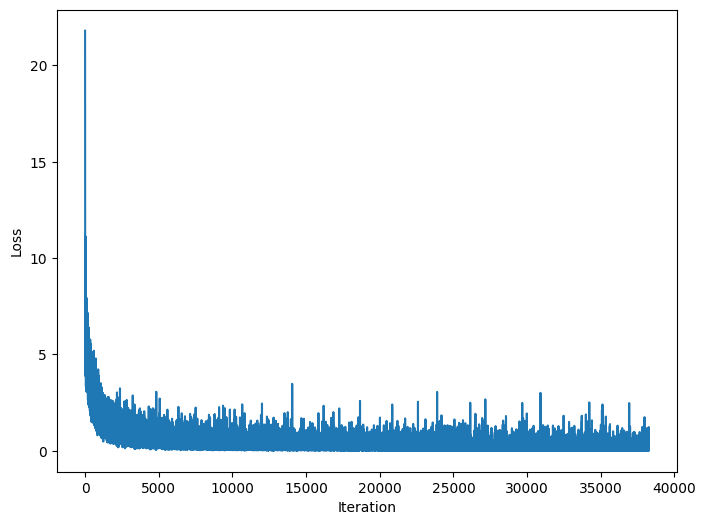

In [17]:
"""Cell 15: Reporting the final loss, dimensions of prediction and true output, vectors and plotting the loss"""

print("Final loss:", np.sum(losses[-len(losses):])/len(losses))  # Report the loss

print("y prediction vectors:", y_predict, "size:", y_predict.shape)
print("true y vector:", dataset_test.y_data, "size:", dataset_test.y_data.shape )


plot_loss(losses) # Plotting the loss function


# **Part 3**


4. 4. Each training/testing example in the output has the form:

[𝑦1, 𝑦2 ,… , 𝑦𝑐 ], 𝑓𝑜𝑟 𝑐 = number of classes

To get a sense of what this looks like, make a table of **the first training example** with the
following format, showing all the rows (the one below is shortened):
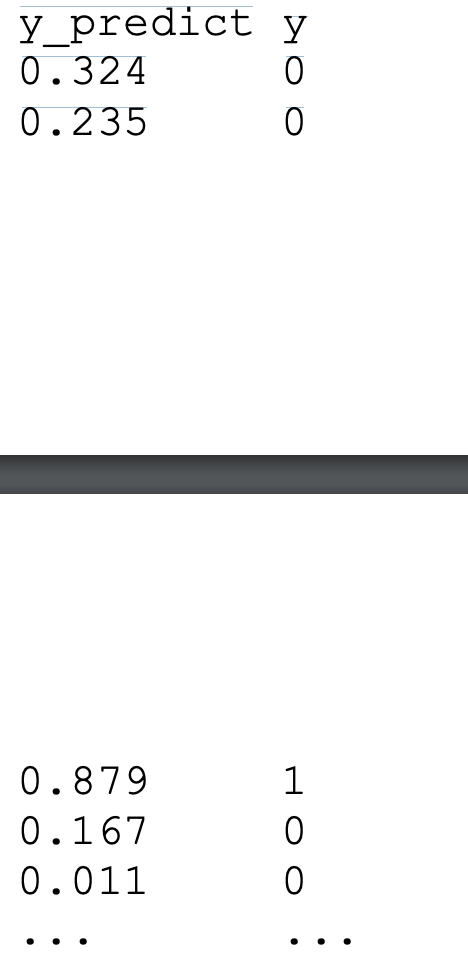




In [18]:
"""Cell 16: Table of predictions and true ys"""

#THIS IS ONLY THE FIRST TRAINING/TESTING EXAMPLE!!!!!
import numpy as np
import pandas as pd


data = {'y_predict': np.ravel(y_predict[0]), "y": np.ravel(dataset_test.y_data[0])}
print(np.argmax(np.ravel(y_predict[0])))

ypredictAndTrueTable = pd.DataFrame(data = data)
print(ypredictAndTrueTable)

8
    y_predict    y
0   -0.777467  0.0
1   -1.374974  0.0
2   -0.898727  0.0
3   -0.701469  0.0
4   -3.006265  0.0
5   -0.800085  0.0
6   -1.089566  0.0
7   -9.259452  0.0
8   12.600244  1.0
9   -4.631131  0.0
10  -4.135623  0.0
11  -3.555473  0.0
12  -1.850466  0.0
13   0.248921  0.0
14  -0.549511  0.0
15   2.742793  0.0
16  -3.554317  0.0
17  -7.494641  0.0
18   1.669443  0.0
19   3.240846  0.0
20   3.005817  0.0
21   0.341402  0.0
22  -7.018807  0.0
23  -2.773203  0.0
24  -1.995544  0.0
25   0.817851  0.0
26   2.804613  0.0
27  -4.273245  0.0
28   4.629512  0.0
29   4.913989  0.0
30  -5.682848  0.0
31  -2.142233  0.0
32  -6.190445  0.0
33  -5.051701  0.0
34   0.599515  0.0
35   0.965889  0.0
36  -3.220597  0.0
37   2.154016  0.0
38  -0.077508  0.0
39  -5.362751  0.0
40  -1.181064  0.0
41  -0.434406  0.0
42  -9.818991  0.0
43   1.084017  0.0
44  -1.743775  0.0
45  -5.770837  0.0


  5. We only want to know which class the model predicted to be the most probable. Use numpy.argmax() to take the raw predicted and expected output vectors and find the index of their maximum value.

Now you can quickly compare whether there is a match or mismatch between your
models prediction and the true value. Print the shape of your argmax vectors to verify they have n entries. Write the first value of y_argmax and y_predict_argmax and compare them to the table you made in #4. Does the relationship between these values and your #4 values make sense. Do you expect the y_predict argmax to match your truth set?


The relationship does make sense; we expect the argmaxes to match. This is because the prediction represnts the expected curve, which approximates the function in question. As such, the maxima and minima locations of the predictions should be the same as the function itself.  

In [19]:
"""Cell 17, Argmax of the prediction and true vectors."""
#Q5
#in this case, n entries = length of flattened array = #training examples * #numberclasses = 3826 * 46 = 175996
#this is the first example


from numpy import argmax as argmax

#max index of the raw predicted vector
print("shape of argmax Predict Vector:", len(np.ravel(y_predict)))
maxRawPredictVector = argmax(y_predict[0])
print("predicted argmax:", maxRawPredictVector)
#print("Argmax Vector:", y_predict[maxRawPredictVector])

#max in dex of the expected output vector
#print(max(np.ravel(dataset_train.y_data)))
#print(dataset_test.y_data.shape)

print("")

print("shape of argmax Expected Vector:", len(np.ravel(dataset_test.y_data)))
maxExpectedOutputVector = argmax(dataset_test.y_data[0])
print("expected argmax:", int(maxExpectedOutputVector))
#print("Argmax Vector:", dataset_test.y_data[maxExpectedOutputVector])

#Q6

#get classfication accuracy percentage

#getting predicted value argmaxs of both as above by going over both vectors at once

numberOfTrials = len(y_predict)
correctPredictions = 0
for yPredictionVector,yTrueVector in zip(y_predict,dataset_test.y_data):
  predIndex,trueIndex = np.argmax(yPredictionVector),np.argmax(yTrueVector)
  #print(predIndex,trueIndex)
  correctPredictions += (predIndex == trueIndex)

correctTimesProportion =  correctPredictions/numberOfTrials

print("")

print("Percentage accuracy:", float(correctTimesProportion*100), "%")





shape of argmax Predict Vector: 175996
predicted argmax: 8

shape of argmax Expected Vector: 175996
expected argmax: 8

Percentage accuracy: 96.23627471923828 %


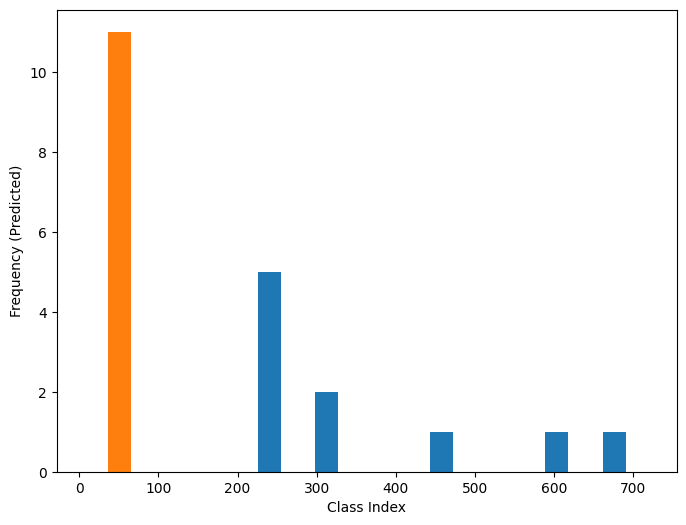

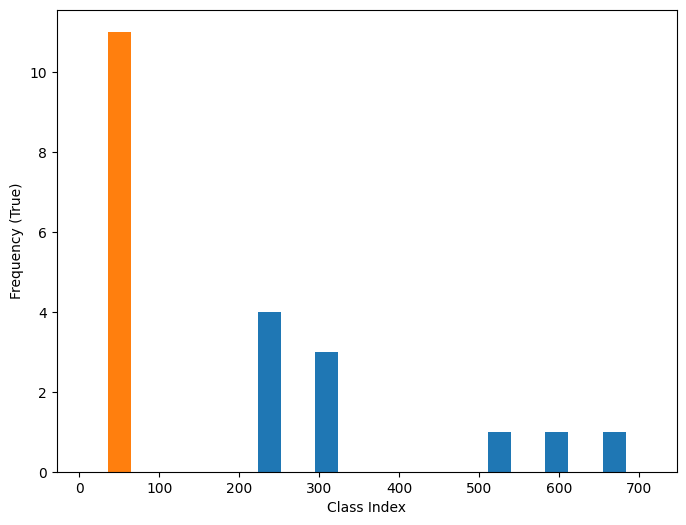

In [20]:

"Cell 18: plotting a histogram of the argmax values for true and predicted y vectors"""

#predicted y
from numpy import histogram as histo
from matplotlib import pyplot as plt

fig1 = plt.figure(1)
fig1.set_size_inches(8,6)

ax = plt.axes()
ax.set_xlabel("Class Index")
ax.set_ylabel("Frequency (Predicted)")
x_Range = list(range(len(y_predict)))

predictedHisto = histo(  [np.argmax(yPredictionVector) for yPredictionVector in y_predict] )
plt.hist(predictedHisto)

fig1.show()

fig2 = plt.figure(2)
fig2.set_size_inches(8,6)

ax = plt.axes()
ax.set_xlabel("Class Index")
ax.set_ylabel("Frequency (True)")
x_Range = list(range(len(y_predict)))

trueHisto = histo(  [np.argmax(yPredictionVector) for yPredictionVector in dataset_test.y_data] )
plt.hist(trueHisto)

fig2.show()



plt.show()
plt.close()


# **Part 4**

Changing to Cross Entropy Loss function.

Omitted instructions for clarity...in the HW assignment. Edits are explained by a comment in train_batch.



# **Part 5**

Here you are free to make any edits to the model you think are worthwhile, and you can try your best to maximize the accuracy of its predictions by tuning each hyperparameter. If instead you are interested in generating a minimal model, or exploring which gene subset has the greatest predictive value, these are both interesting questions that you can answer by rewriting
the model. As long as you explain your results using prediction, accuracy, and confusion, and you demonstrate an understanding of the fundamentals, any configuration is fine.

1. Make a normalized confusion matrix with your results, and plot it as a heat map (pyplot.imshow). Make sure the axis are labelled either with the text name of each class or something that will allow you to look up the class name.

Confusion Matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

See this page for instructions on displaying a normalized confusion matrix:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

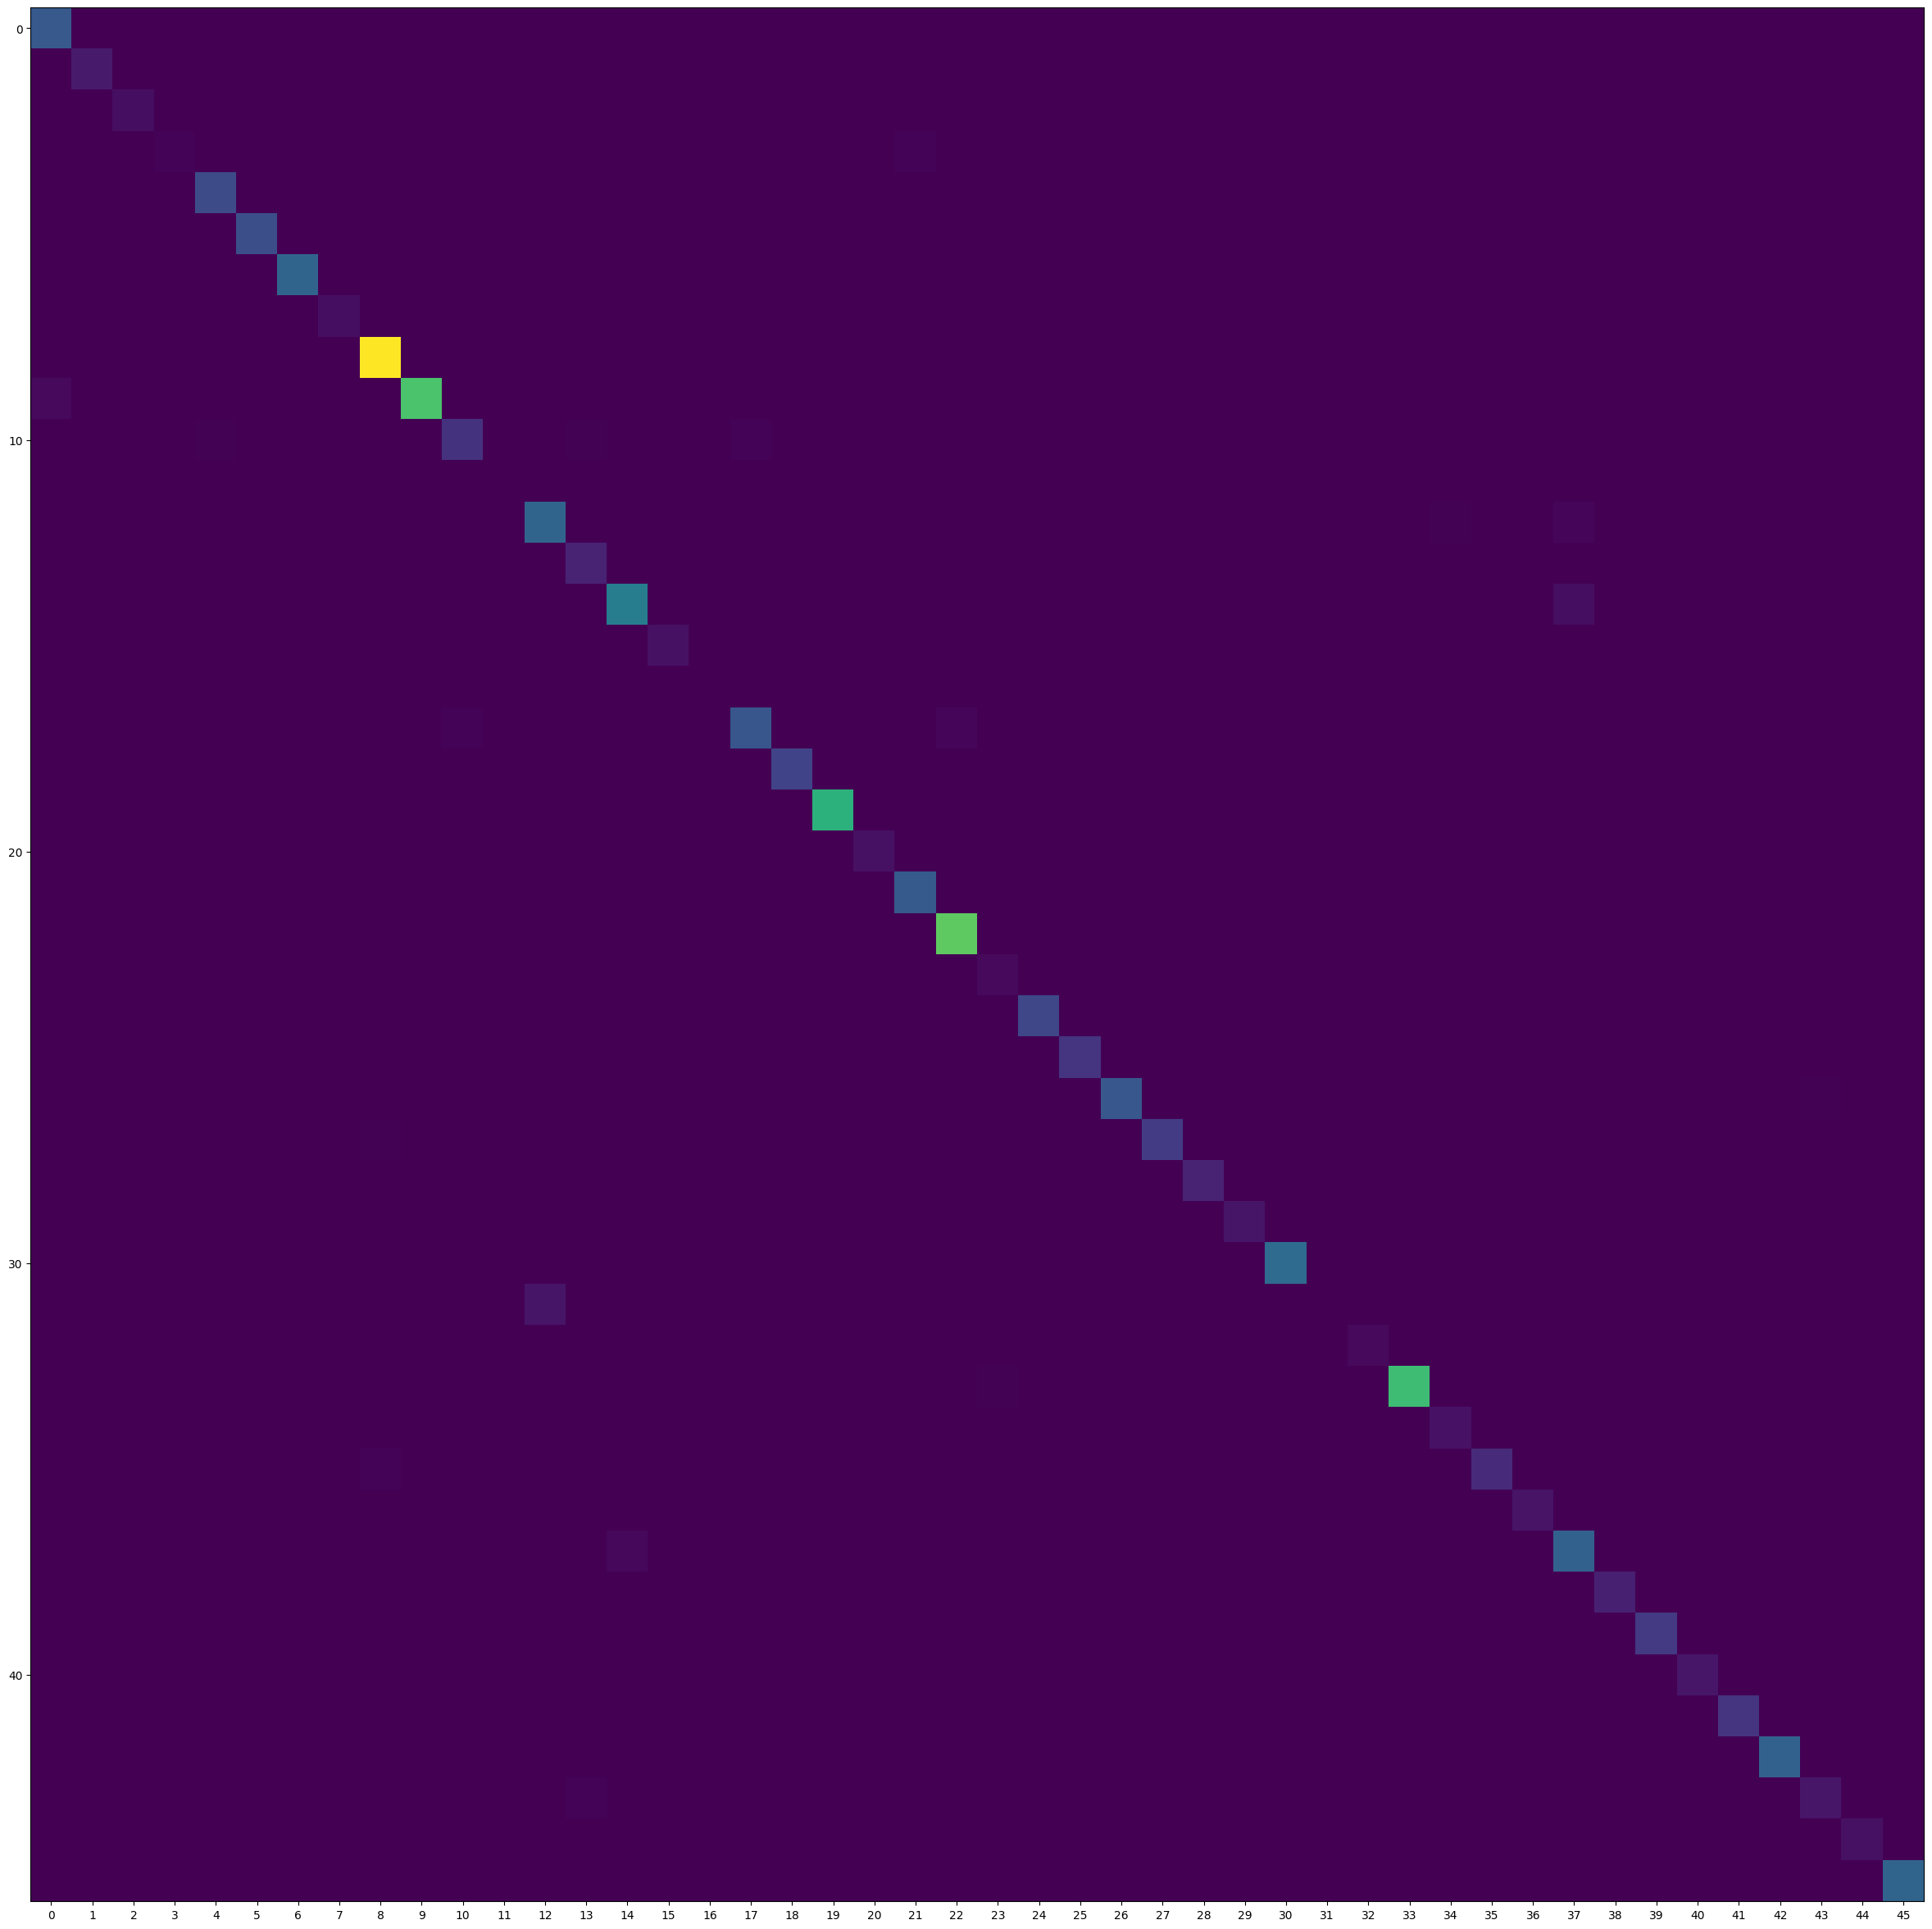

In [21]:
"""Cell 19: Confusion matrix of predicted and true vectors as a heatmap"""
"""Answer to Pt.5 Q1"""


from sklearn.metrics import confusion_matrix as cMatrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt


fig1 = plt.figure(1)
fig1.set_size_inches(30,30)

ax = plt.axes()




argMaxesPredictions = [np.argmax(yPredictionVector) for yPredictionVector in y_predict]
argMaxesTrues = [np.argmax(yPredictionVector) for yPredictionVector in dataset_test.y_data]




labels = list(y_index_key.keys())

#for pred, true in zip(argMaxesPredictions, argMaxesTrues):
  #print(pred,true)


#creating confusion matrix and displaying
thisConfusionMatrix = cMatrix(argMaxesTrues, argMaxesPredictions, normalize = 'all')
ax.imshow(thisConfusionMatrix)

#labeling the axes with the proper class type number
#this can be used to go back to the proper tissue type with y_index_key

ticks = range(46)
labels = list(y_index_key.values())
ax.set_xticks(ticks, labels=labels)



fig1.show()





In [24]:
"""Cell 20: Building classification report"""
from sklearn.metrics import classification_report as clsftnReport

#argmax predictions/trues
argMaxesPredictions = [np.argmax(yPredictionVector) for yPredictionVector in y_predict]
argMaxesTrues = [np.argmax(yPredictionVector) for yPredictionVector in dataset_test.y_data]

#getting the names of the tissues from the y_index_key
tissueNames = list(y_index_key.keys())

#building classification report
thisReport = clsftnReport(argMaxesTrues,argMaxesPredictions, target_names = tissueNames)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
"""Cell 21: Print and intepret the classification report """

"""Used for P5 Q5"""
from math import e
#showing first 5 rows
print(thisReport)


#getting the frequencies of the test data and adding to dictionary
countsDict = {}

totalCounts = 0
for x,y in dataset_test:

  currentClass = list(y).index(1)
  if currentClass in countsDict.keys():
    countsDict[currentClass] += 1
    totalCounts +=1
  else:
    countsDict[currentClass] = 1
    totalCounts += 1

#sorting old dictionary
newDict = dict(sorted(countsDict.items(), key = lambda x: x[1], reverse = True))

#getting the relative frequencies of each class
frequencyDict = {}
sum = 0
for key, value in newDict.items():
  sum+=value/totalCounts
  tissueType = list(y_index_key.keys())[list(y_index_key.values()).index(key)]

  frequencyDict[tissueType] = value/totalCounts

print(frequencyDict)



                            precision    recall  f1-score   support

            Adipose Tissue       0.90      1.00      0.95       103
             Adrenal Gland       0.96      1.00      0.98        26
             Adrenal gland       1.00      0.93      0.97        15
                 Bile duct       0.80      0.44      0.57         9
                   Bladder       0.91      0.99      0.95        87
                     Blood       1.00      1.00      1.00        89
              Blood Vessel       0.99      0.98      0.99       121
               Bone Marrow       1.00      1.00      1.00        14
                     Brain       0.98      1.00      0.99       369
                    Breast       1.00      0.95      0.97       278
                    Cervix       0.95      0.87      0.91        62
              Cervix Uteri       0.00      0.00      0.00         2
                     Colon       0.84      0.93      0.88       128
               Endometrium       0.86      0.90

# **Part 1 Answers**
Questions:

*1*. How many training examples are in the dataset?
19126

*2*. What proportion (%) of the full dataset has been set aside for testing?
3826/(15300+3826); this is approximately 20% of the data (80-20 split).

*3*. How many gene expression values will be used as input to classify each sample in the dataset?
There are 5172 of them per expression vector.

*4*. How many tissue types are there in the data labels?
46; the same number as number of output classes.

*5*. When performing classification with a neural network, the output vector is an array with n variables, where each variable describes the probability that your input belongs to one class in your classification problem. Based on this information, what should be the size of your output layer in the neural network?

If n = number of training examples and there are 46 possible classes, the output vector consists of an array of this size: n * 46

*6*. How will you know which index in the output corresponds to which tissue type once you feed your data into the model and get your output?

We formed a dictionary while loading the data called y_index_key. It pairs each index of the vector with its tissue type. We will supply the resulting output indices into the dictionary to return the tissue types that correspond to them.

# **Part 2 Answers**

They are left above in the code blocks for Pt. 2, since they aren't text heavy.

# **Part 3 Answers**

For this section, you will be assessing the performance of a draft model.


1. The initial model will (probably) be so bad that you will be unable to use it as a starting point. Perform some changes to your model architecture and training parameters until your final loss is no longer undefined (nan). Don’t edit the loss function (we will do this later in the assignment). Once your model consistently obtains a reasonable loss (usually below 1) you can start working on assessing its performance. Describe the changes you made.

It turns out that the model as written obtained a final loss of .021. As such, no changes are (currently) there.

2. The first step towards assessing your model will be to compare your predictions to their expected values. Edit your test methods so they return the true y vectors and the y prediction vectors back to your final code block. Print the shapes of these arrays to ensure they are exactly the same dimensions. What are their dimensions?

They are 3826 x 46, as expected.

3. Do these match your test set size from part 1?

Yes.



4. Rewrite the final code block that declares the dataset and calls run(). You will have to
initialize the PrimarySiteDataset class for your training and testing set like so:

x_train_path = "x_train.npz"

y_train_path = "y_train.npz"

x_test_path = "x_test.npz"

y_test_path = "y_test.npz"

dataset_train = PrimarySiteDataset(x_path=x_train_path,
y_path=y_train_path)

dataset_test = PrimarySiteDataset(x_path=x_test_path,
y_path=y_test_path)


# **Part 3 Written Answers**

5. We only want to know which class the model predicted to be the most probable. Use numpy.argmax() to take the raw predicted and expected output vectors and find the index of their maximum value.

Now you can quickly compare whether there is a match or mismatch between your models prediction and the true value. Print the shape of your argmax vectors to verify they have n entries. Write the first value of y_argmax and y_predict_argmax and compare them to the table you made in #4. Does the relationship between these values and your #4 values make sense. Do you expect the y_predict argmax to match your truth set?

See Code Cell 17...both of them are 8, which is the the index in the table in the true classification vector where there is a 1, as expected.

The relationship does make sense; we expect the argmaxes to match. This is because the prediction should approximate the target function.

6. Add to your above method to calculate the percentage of matches between your predictions and known values. What is your overall classification accuracy? It’s expected that it won’t be great at this stage.

That's true; before any adjustment, it was about 9.64% accurate.

Run 1: After adjusting the learning rate, activation function, and optimizer, it is 10 times that.

7. Plot a histogram of your argmax values for y, and for predicted y. How do they compare? In which scenarios would you expect your predicted distribution to match or not match your true distribution? Your truth set for y should have a histogram that looks something like this (I won't paste it this time to reduce the size of this cell):

See Code Cell 18...

They are similar in shape; we would expect them to match if the classification accuracy of the neural network is high and vice versa.

# **Part 5 Answers**

**Log of Changes:**

1) Changed the learning rate from 1e-5 to 1e-7
-> Accuracy of 72% to .048!!!!

->Eventually changed it back and added constant to get current accuracy rate.

2) Implemented the SGD Optimizer to improve runtime:
https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
->Cut runtime down to about 2 minutes from 5

**Questions**

*1.* Make a normalized confusion matrix with your results, and plot it as a heat map (pyplot.imshow). Make sure the axis are labelled either with the text name of each class or something that will allow you to look up the class name.
Confusion Matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

See this page for instructions on displaying a normalized confusion matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

See Code Cell 11.



*2.* Once you have something you are satisfied with, report how the data was processed (if different from the provided script), your architecture, and your training parameters.

The data was processed as it was in the provided script. This is the architecture...:

-Shallow Neural Network

-4 layers; 2 linear hidden layers with 40 nodes each -Layers' activation functions are all relu

-Using SGD optimizer like we did in class (originally Adam function, but runtime was too long and accuracy was lower)

-Using the Cross Entropy Loss function

Training Parameters:

Split: 0%/20% train/test

Learning Rate Hyperparameter: 1e-4 + .3e-6

*3.* What is your final accuracy (overall percent)?

96%!

*4.* What tissue types were most “confusing” for the model? Answer in terms of which classes were most inter-confused, and quantitative accuracy for each of the most confused classes. You may use this method to compute quantitative stats for each class.
This method: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

5 most confusing classes:

Bile Duct biopsies - only 2/3 precision here (0.67)

Uterus biopsies - only around 3/4 precision (0.73)

Bone biopsies - 0.82 precision

Colon - 0.83 precision

Endometrium - 0.84 precision


*5.* How does each class’s frequency correlate (if at all) to the model’s performance for that class, qualitatively or quantitatively?

There is a weak negative correlation between model performance and class relative frequency. For example, the most confusing classes, bile dict biopsy, is the third least frequent class present, and the next most confusion, uterus, is this 17th least frequent. Qualitatively speaking, all of the most confusion classes below 85% precision levels are toward the bottom of the class distribution.  

See Code Cell 12...

*6.* Describe your strategy for choosing hyperparameters. Did you use any form of evaluation to inform your decisions? If you have recorded the steps you took to reach your final configuration, write them here.

First, I assessed the runtime of the NN using each of several possible optimizers, with a simple stopwatch to record runtimes. The default optimizer (Adam function) had a runtime of close to 5 minutes, whereas SGD like we used in class is closer to 1.5.

Next, using various learning rates, I assessed the accuracy percentage to determine which learning rate would be most appropriate. I first changed the order of magnitude by two greater or two lesser, and saw that there were a great gain in changing the order from -7 to -5. However, lots of accuracy was lost when changing the order to -4.

Then, I chose to add a term of order -6 to the learning rate, and chose different mantissas by inspection before obtaining the current one, .3.

7. Assume you have a network with the following dimensions:
Input: 32 nodes
Hidden: 64 nodes
Output: 4 nodes

What is the total number of weight parameters you are optimizing?
Assuming that the layers are linear...

32 nodes -> 64 nodes -> 4 nodes

32x64 + 64x4 weights = 2304 weights

What is the total number of bias parameters you are optimizing?

Assuming one bias per hidden node in each activation function, you are optimizing 64 of them.


For **your network**, how many weight parameters are you optimizing? How does this compare to the number of training examples in your dataset?

Here we have:

Input: 5172 nodes
Hidden 1: 40 nodes
Hidden 2: 40 nodes
Output: 46 nodes

5172 nodes -> 40 nodes -> 40 nodes -> 46 nodes

5172x40 + 40x40 + 40x46 = 210320 weights, much greater than the 15300 training examples.  


8. Given these numbers, do you think there is any risk of overfitting? Considering the size and diversity of this test set would you be confident that this model will generalize to all future data you might encounter?

Since the number of training examples is far less than the number of parameters optimized, there is a very high risk of overfitting. Thus, the model would probably not generalize too well to future data.

9. Do you think there is a better combination of hyperparameters (not model parameters) with respect to the test results? Are there any obvious shortcomings in your opinion? If you had infinite time/resources how might you improve your methods?

Yes, I only tested the few combinations listeed in my answer to Q6. There are a host of other optimizers with their own optimal set of learning rates. If I had infinite time, I would try all of the various optimizers with Pytorch and vary the learning rates several times for each. With quicker runtime (which could use the TPU that I don't current have a license to use), that would make it even more efficient. Ultimately, my opinion on which are best is determined by how willing I am to optimize the hyperparameters.

10. Other than the hyperparameters, what might affect this model’s performance?

The train/test split could be better configured to ensure less overfitting (also the architecture of the NN, as discussed in 8). Addionally, the optimzers and actual activation functions used in the hidden layers too could be changed to improve performance.

11. You may have noticed that the “adrenal gland” tissue label is duplicated. If your model is actually separating them, what might that indicate about its ability to generalize to new “adrenal gland” tissue types?

It indicates that the model should be able to seperate any new adrenal gland tissue vectors that are added. This is for better or for worse, since the user might intend for the new vector to be classified as the old class.
